# Load New York parquet data

In [21]:
# === Load New York parquet data ===

import pandas as pd

# 1) read parquet
path = "../data/new-york/train-00000-of-00001.parquet"
df = pd.read_parquet(path)

# 2) keep key column
needed_cols = ["user_id", "venue_id", "latitude", "longitude", "trail_id", "timestamp"]
df = df[needed_cols].rename(columns={"timestamp": "ts"})

# 3) Convert time columns to datetime
df["ts"] = pd.to_datetime(df["ts"], utc=True)

# change to newyork local time
df["ts"] = df["ts"].dt.tz_convert("America/New_York")

# 4) Delete rows with missing coordinates
df = df.dropna(subset=["latitude", "longitude"])

# 5) Basic checks
print("Data shape:", df.shape)
print(df.info())
display(df.head())

Data shape: (176934, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 176934 entries, 0 to 190738
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype                           
---  ------     --------------   -----                           
 0   user_id    176934 non-null  int64                           
 1   venue_id   176934 non-null  int64                           
 2   latitude   176934 non-null  float64                         
 3   longitude  176934 non-null  float64                         
 4   trail_id   176934 non-null  object                          
 5   ts         176934 non-null  datetime64[ns, America/New_York]
dtypes: datetime64[ns, America/New_York](1), float64(2), int64(2), object(1)
memory usage: 9.4+ MB
None


,user_id,venue_id,latitude,longitude,trail_id,ts
0,1,29958,40.731713,-73.841905,2013_37,2012-07-02 13:48:00-04:00
1,1,12494,40.723900,-73.847908,2013_37,2012-07-02 13:50:00-04:00
2,1,26526,40.718430,-73.849100,2013_37,2012-07-02 13:52:00-04:00
3,1,22495,40.734141,-73.870845,2013_37,2012-07-02 13:57:00-04:00
4,1,26656,40.725528,-73.849582,2013_37,2012-07-02 14:00:00-04:00


# construct traj and clean

In [22]:
# === 3A) Track Construction & Basic Cleaning ===
import numpy as np
import pandas as pd

traj = (
    df.loc[:, ["user_id", "venue_id", "latitude", "longitude", "ts"]]
      # Sort by user + time
      .sort_values(["user_id", "ts"])
      # Only one duplicate record of the same user and the same timestamp is retained
      .drop_duplicates(subset=["user_id", "ts"])
)

# (Optional) Coordinate plausibility filter: Approximate New York area (conservative value)
# NY_LAT_MIN, NY_LAT_MAX = 40.3, 41.1
# NY_LON_MIN, NY_LON_MAX = -74.4, -73.3
# mask_nyc = (
#     (traj["latitude"].between(NY_LAT_MIN, NY_LAT_MAX))
#     & (traj["longitude"].between(NY_LON_MIN, NY_LON_MAX))
# )
# traj = traj.loc[mask_nyc].reset_index(drop=True)

print("Trajectory rows after cleaning:", traj.shape[0])
display(traj.head())

Trajectory rows after cleaning: 176934


,user_id,venue_id,latitude,longitude,ts
0,1,29958,40.731713,-73.841905,2012-07-02 13:48:00-04:00
1,1,12494,40.723900,-73.847908,2012-07-02 13:50:00-04:00
2,1,26526,40.718430,-73.849100,2012-07-02 13:52:00-04:00
3,1,22495,40.734141,-73.870845,2012-07-02 13:57:00-04:00
4,1,26656,40.725528,-73.849582,2012-07-02 14:00:00-04:00


In [23]:
# === 3B) Random check: randomly select 3 users to check their before and after records ===
rng = np.random.default_rng(42)
some_users = rng.choice(traj["user_id"].unique(), size=min(3, traj["user_id"].nunique()), replace=False)
print("Sample users:", some_users)

for u in some_users:
    t = traj[traj["user_id"] == u]
    print(f"\n== user {u} ==")
    display(t.head(5))
    display(t.tail(5))
    # Fast sanity: whether the time is monotonous, number of points
    print("n_points:", len(t), "time_increasing?", t["ts"].is_monotonic_increasing)

Sample users: [178975  19936 206843]

== user 178975 ==


,user_id,venue_id,latitude,longitude,ts
89855,178975,2907,40.719475,-74.004095,2012-05-04 08:28:00-04:00
89856,178975,7639,40.773786,-73.871872,2012-05-04 12:04:00-04:00
89857,178975,6151,40.725720,-74.005686,2012-05-18 08:40:00-04:00
89858,178975,17277,40.725621,-74.005027,2012-05-18 08:59:00-04:00
89859,178975,807,40.725633,-74.007500,2012-05-18 18:02:00-04:00


,user_id,venue_id,latitude,longitude,ts
185548,178975,40915,40.722100,-73.988225,2017-12-18 20:55:00-05:00
185549,178975,1877,40.711716,-73.949009,2017-12-24 09:08:00-05:00
185550,178975,8410,40.750752,-73.993542,2017-12-29 19:24:00-05:00
185551,178975,19904,40.718802,-73.953267,2018-07-19 11:51:00-04:00
185552,178975,1873,40.749958,-73.990167,2018-07-19 19:47:00-04:00


n_points: 26 time_increasing? True

== user 19936 ==


,user_id,venue_id,latitude,longitude,ts
15607,19936,16114,40.638452,-74.078630,2012-05-05 13:15:00-04:00
15608,19936,436,40.720604,-73.954723,2012-05-05 16:55:00-04:00
15609,19936,5878,40.745231,-73.945669,2012-05-05 17:48:00-04:00
15610,19936,2261,40.747188,-73.889374,2012-05-05 18:46:00-04:00
15611,19936,709,40.716190,-73.999794,2012-07-03 22:13:00-04:00


,user_id,venue_id,latitude,longitude,ts
15622,19936,375,40.730258,-73.991310,2012-11-28 20:12:00-05:00
15623,19936,155,40.730762,-74.000947,2013-03-29 22:34:00-04:00
15624,19936,275,40.746015,-73.977926,2013-03-30 00:41:00-04:00
15625,19936,35641,40.722857,-73.982906,2013-08-31 11:56:00-04:00
15626,19936,2294,40.795841,-73.926013,2013-08-31 15:08:00-04:00


n_points: 20 time_increasing? True

== user 206843 ==


,user_id,venue_id,latitude,longitude,ts
122144,206843,37932,40.789362,-73.978225,2012-05-11 11:59:00-04:00
122145,206843,12436,40.787122,-73.978043,2012-05-11 13:56:00-04:00
122146,206843,816,40.753873,-73.983629,2012-05-11 14:28:00-04:00
122147,206843,386,40.721636,-73.995635,2012-10-12 21:53:00-04:00
122148,206843,27463,40.742088,-74.003624,2012-10-12 23:47:00-04:00


,user_id,venue_id,latitude,longitude,ts
122144,206843,37932,40.789362,-73.978225,2012-05-11 11:59:00-04:00
122145,206843,12436,40.787122,-73.978043,2012-05-11 13:56:00-04:00
122146,206843,816,40.753873,-73.983629,2012-05-11 14:28:00-04:00
122147,206843,386,40.721636,-73.995635,2012-10-12 21:53:00-04:00
122148,206843,27463,40.742088,-74.003624,2012-10-12 23:47:00-04:00


n_points: 5 time_increasing? True


# q

Users counted: 6917


,user_id,obs_hours,total_hours,q
0,79344,1,1,0.0
1,203258,2,2,0.0
2,46295,1,1,0.0
3,192570,2,2,0.0
4,98131,2,2,0.0



q summary:


count    6917.000000
mean        0.945078
std         0.143059
min         0.000000
25%         0.968254
50%         0.994690
75%         0.997823
90%         0.998807
95%         0.999148
max         0.999939
Name: q, dtype: float64

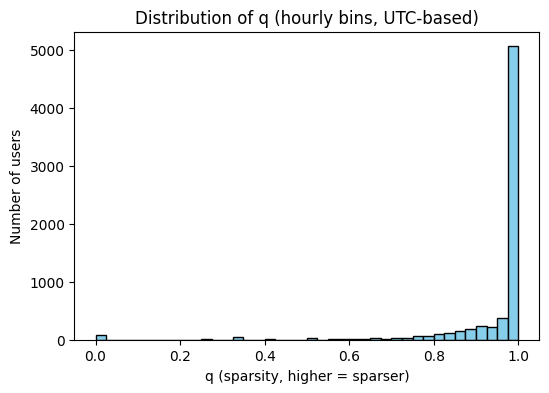

In [24]:
# === 4) Sparsity q (Use UTC to avoid DST ambiguity) ===

import matplotlib.pyplot as plt

# 1) Copy the track and create a new UTC time column
traj_hour = traj.copy()
traj_hour["ts_utc"] = traj_hour["ts"].dt.tz_convert("UTC")

# 2) Discrete into hourly buckets
traj_hour["ts_hour"] = traj_hour["ts_utc"].dt.floor("h")

# 3) calculate by groups
g = traj_hour.groupby("user_id", observed=True)

# Numerator: Number of recorded hourly buckets
obs_hours = g["ts_hour"].nunique()

# Denominator: Total number of hour buckets = first and last hour span + 1
min_hour = g["ts_hour"].min()
max_hour = g["ts_hour"].max()
total_hours = ((max_hour - min_hour) / pd.Timedelta(hours=1)).astype("int64") + 1

# Defense: Set span anomaly (total_hours <= 0) to 1
total_hours = total_hours.mask(total_hours <= 0, 1)

# 4) Calculate q
q = 1.0 - (obs_hours / total_hours)

user_q = (
    pd.DataFrame({
        "user_id": obs_hours.index,
        "obs_hours": obs_hours.values,
        "total_hours": total_hours.values,
        "q": q.values,
    })
    .sort_values("q")
    .reset_index(drop=True)
)

print("Users counted:", len(user_q))
display(user_q.head())

# 5) Distribution Statistics
print("\nq summary:")
display(user_q["q"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95]))

# 6) plot
plt.figure(figsize=(6,4))
plt.hist(user_q["q"].clip(0,1), bins=40, color="skyblue", edgecolor="black")
plt.xlabel("q (sparsity, higher = sparser)")
plt.ylabel("Number of users")
plt.title("Distribution of q (hourly bins, UTC-based)")
plt.show()

# filter out to get traj that valid

In [25]:
# === Filter sparse trajectories and output the number of filtered users ===

# paramter
q_thresh = 0.8      
min_points = 5     

user_points = traj.groupby("user_id", observed=True).size().rename("n_points")

user_stats = (
    user_q[["user_id", "q"]]
    .merge(user_points, on="user_id", how="left")
    .fillna({"n_points": 0})
)

valid_users = user_stats[
    (user_stats["q"] < q_thresh) &
    (user_stats["n_points"] >= min_points)
].copy()

total_users = user_stats.shape[0]
n_valid = valid_users.shape[0]
pct_valid = (n_valid / total_users * 100) if total_users else 0.0

print(f"Total users: {total_users}")
print(f"Valid users (q < {q_thresh} & n_points >= {min_points}): {n_valid} ({pct_valid:.2f}%)")

display(valid_users.describe(percentiles=[0.25, 0.5, 0.75]))

valid_user_ids = set(valid_users["user_id"].tolist())
traj_valid = traj[traj["user_id"].isin(valid_user_ids)].reset_index(drop=True)

print("Rows in traj_valid:", len(traj_valid))
display(traj_valid.head())

Total users: 6917
Valid users (q < 0.8 & n_points >= 5): 214 (3.09%)


,user_id,q,n_points
count,214.000000,214.000000,214.000000
mean,135404.953271,0.703999,12.700935
std,88271.454903,0.143162,8.423882
min,240.000000,0.000000,5.000000
25%,64378.750000,0.697936,7.000000
50%,135254.000000,0.750000,10.000000
75%,200721.750000,0.777778,15.000000
max,395212.000000,0.796610,57.000000


Rows in traj_valid: 2718


,user_id,venue_id,latitude,longitude,ts
0,240,2588,40.757346,-73.985850,2017-12-24 12:48:00-05:00
1,240,4306,40.705967,-73.996707,2017-12-24 15:11:00-05:00
2,240,44753,40.703053,-73.994004,2017-12-24 15:57:00-05:00
3,240,14005,40.763358,-73.981742,2017-12-24 20:19:00-05:00
4,240,14635,40.765437,-73.983641,2017-12-24 21:55:00-05:00


# Entropy

Users with entropy calculated: 214


,user_id,N,S_unc,S_rand
0,240,10,3.321928,3.321928
1,741,11,3.459432,3.459432
2,2262,5,2.321928,2.321928
3,2291,32,4.841625,5.000000
4,2328,12,3.546594,3.584963



Entropy summary:


,S_unc,S_rand,N
count,214.000000,214.000000,214.000000
mean,3.365962,3.384766,12.158879
std,0.758809,0.763759,7.769749
min,1.918296,2.000000,4.000000
25%,2.807355,2.807355,7.000000
50%,3.321928,3.321928,10.000000
75%,3.906891,3.906891,15.000000
90%,4.403364,4.439297,21.700000
95%,4.658591,4.719496,26.350000
max,5.762715,5.781360,55.000000


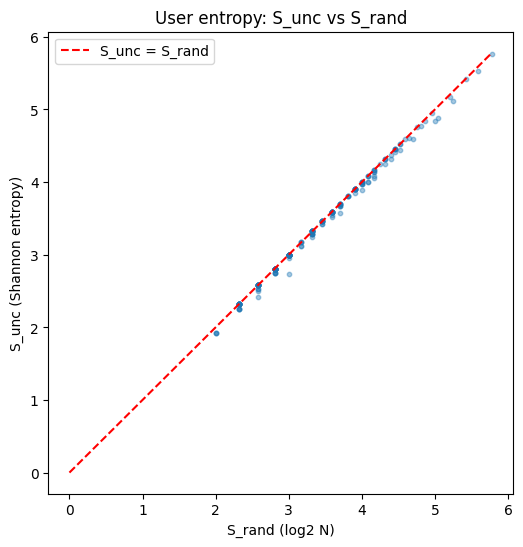

In [26]:
# === 5) Calculate entropy S_unc and S_rand ===

import numpy as np

def shannon_entropy(counts):
    """Given an array of location visit frequencies, return the Shannon entropy (base log2)"""
    probs = counts / counts.sum()
    return -(probs * np.log2(probs)).sum()

# 1) Count the frequency of each user's location visits
user_entropy_list = []

for uid, group in traj_valid.groupby("user_id", observed=True):
    venue_counts = group["venue_id"].value_counts()
    N = len(venue_counts)  
    
    if N <= 1:
        S_unc = 0.0
        S_rand = 0.0
    else:
        S_unc = shannon_entropy(venue_counts.values)
        S_rand = np.log2(N)
    
    user_entropy_list.append({
        "user_id": uid,
        "N": N,
        "S_unc": S_unc,
        "S_rand": S_rand
    })

user_entropy = pd.DataFrame(user_entropy_list)

print("Users with entropy calculated:", len(user_entropy))
display(user_entropy.head())

# distribution stats
print("\nEntropy summary:")
display(user_entropy[["S_unc", "S_rand", "N"]].describe(percentiles=[0.25,0.5,0.75,0.9,0.95]))

# plot：S_unc vs S_rand
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(user_entropy["S_rand"], user_entropy["S_unc"], alpha=0.4, s=10)
plt.xlabel("S_rand (log2 N)")
plt.ylabel("S_unc (Shannon entropy)")
plt.title("User entropy: S_unc vs S_rand")
plt.plot([0, user_entropy["S_rand"].max()],
         [0, user_entropy["S_rand"].max()],
         "r--", label="S_unc = S_rand")
plt.legend()
plt.show()


# Π_max

Users with Pi_max calculated: 214


,user_id,N,S_unc,S_rand,Pi_max
0,240,10,3.321928,3.321928,0.100000
1,741,11,3.459432,3.459432,0.090909
2,2262,5,2.321928,2.321928,0.200000
3,2291,32,4.841625,5.000000,1.000000
4,2328,12,3.546594,3.584963,1.000000



Π_max summary:


count    214.000000
mean       0.428238
std        0.422511
min        0.032258
25%        0.100000
50%        0.142857
75%        1.000000
90%        1.000000
95%        1.000000
max        1.000000
Name: Pi_max, dtype: float64

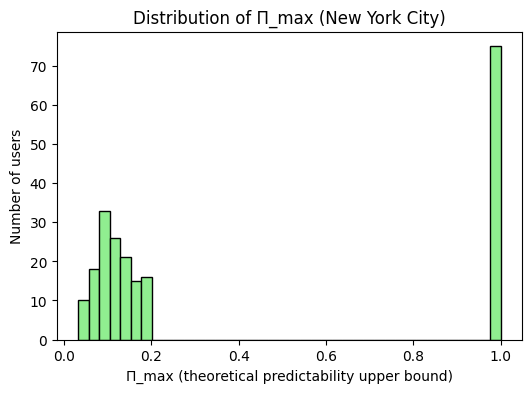

In [27]:
# === 6) Calculate the upper limit of predictability Π_max ===

import math

def fano_equation(p, S, N):
    """
Right side of the Fano equation:
S = H(p) + (1-p)*log2(N-1)
Return f(p) = RHS - S
    """
    if p <= 0 or p >= 1:
        return float("inf")
    H = -(p*math.log2(p) + (1-p)*math.log2(1-p))
    return H + (1-p)*math.log2(N-1) - S

def solve_pimax(S, N, tol=1e-6, max_iter=100):
    """
Given S_unc and N, use bisection to solve Π_max
    """
    if N <= 1 or S <= 0:
        return 1.0  
    
# Bounds: If S >= log2(N), then predictability is close to random
    if S >= math.log2(N):
        return 1.0 / N
    
# Solve equations using bisection method
    low, high = 0.0, 1.0
    for _ in range(max_iter):
        mid = (low + high) / 2
        val = fano_equation(mid, S, N)
        if abs(val) < tol:
            return mid
        if val > 0:
            high = mid
        else:
            low = mid
    return mid

# Calculate Π_max for each user
user_entropy["Pi_max"] = user_entropy.apply(
    lambda row: solve_pimax(row["S_unc"], int(row["N"])), axis=1
)

print("Users with Pi_max calculated:", len(user_entropy))
display(user_entropy.head())

print("\nΠ_max summary:")
display(user_entropy["Pi_max"].describe(percentiles=[0.25,0.5,0.75,0.9,0.95]))

# plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(user_entropy["Pi_max"], bins=40, color="lightgreen", edgecolor="black")
plt.xlabel("Π_max (theoretical predictability upper bound)")
plt.ylabel("Number of users")
plt.title("Distribution of Π_max (New York City)")
plt.show()

# R_g

Users with R_g calculated: 214


/scratch/pbs.6933308.kman.restech.unsw.edu.au/ipykernel_2855874/3653631760.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_rg_for_group)


,user_id,n_points,lat_cm,lon_cm,Rg_km
119,147631,11.0,41.120036,-75.749259,475.294406
82,91572,18.0,40.719813,-73.988700,9.896882
140,183411,10.0,40.773289,-73.923065,9.777518
180,233501,7.0,40.692058,-73.949711,8.527281
207,315959,7.0,40.785889,-73.945015,7.595136



R_g summary (km):


count    214.000000
mean       5.502792
std       32.305980
min        0.265219
25%        2.361578
50%        3.126861
75%        3.895456
90%        5.499065
95%        6.662671
99%        9.614987
max      475.294406
Name: Rg_km, dtype: float64

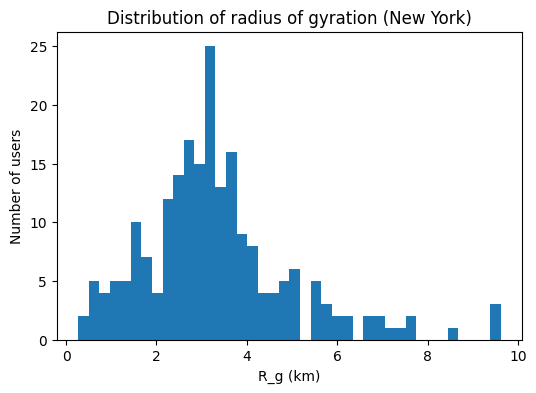


Merged metrics preview:


,user_id,N,S_unc,S_rand,Pi_max,Rg_km,n_points
0,240,10,3.321928,3.321928,0.100000,2.597536,10.0
1,741,11,3.459432,3.459432,0.090909,3.161916,11.0
2,2262,5,2.321928,2.321928,0.200000,0.707610,5.0
3,2291,32,4.841625,5.000000,1.000000,2.159015,37.0
4,2328,12,3.546594,3.584963,1.000000,3.479906,13.0


In [28]:
# === 7) Calculate travel radius R_g (km) ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Haversine distance (vectorized), returns kilometers
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088  # Average radius of the Earth (km)
    lat1 = np.deg2rad(lat1); lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2); lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2.0 * np.arcsin(np.sqrt(a))
    return R * c

# 2)R_g for a single user
def compute_rg_for_group(g):
# Centroid (simple latitude and longitude mean; city scale is sufficient)
    lat_cm = g["latitude"].mean()
    lon_cm = g["longitude"].mean()
# Distance from each point to the centroid (km)
    d = haversine_km(g["latitude"].to_numpy(), g["longitude"].to_numpy(),
                     lat_cm, lon_cm)
    # R_g = sqrt(mean squared distance)
    rg = np.sqrt(np.mean(d**2)) if len(d) >= 2 else 0.0
    return pd.Series({
        "n_points": len(g),
        "lat_cm": lat_cm,
        "lon_cm": lon_cm,
        "Rg_km": float(rg),
    })

# 3) calculate by users
user_rg = (
    traj_valid
    .groupby("user_id", observed=True, sort=False)
    .apply(compute_rg_for_group)
    .reset_index()
    .sort_values("Rg_km", ascending=False)
)

print("Users with R_g calculated:", len(user_rg))
display(user_rg.head())

print("\nR_g summary (km):")
display(user_rg["Rg_km"].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99]))

# 5) plot
plt.figure(figsize=(6,4))
plt.hist(np.clip(user_rg["Rg_km"], 0, np.percentile(user_rg["Rg_km"], 99)), bins=40)
plt.xlabel("R_g (km)")
plt.ylabel("Number of users")
plt.title("Distribution of radius of gyration (New York)")
plt.show()

# 6) Combine R_g into the existing user_entropy / Pi_max to facilitate subsequent linkage analysis
if "user_entropy" in globals():
    user_metrics = user_entropy.merge(user_rg[["user_id", "Rg_km", "n_points"]],
                                      on="user_id", how="left")
else:
    user_metrics = user_rg.copy()

print("\nMerged metrics preview:")
display(user_metrics.head())

# R

Users with R calculated: 214


,user_id,R,N,R_rand
0,240,0.700000,10,0.100000
1,741,1.000000,11,0.090909
2,2262,0.800000,5,0.200000
3,2291,0.513514,32,0.031250
4,2328,0.846154,12,0.083333



R summary:


count    214.000000
mean       0.841610
std        0.158771
min        0.263158
25%        0.769231
50%        0.869565
75%        1.000000
90%        1.000000
95%        1.000000
max        1.000000
Name: R, dtype: float64

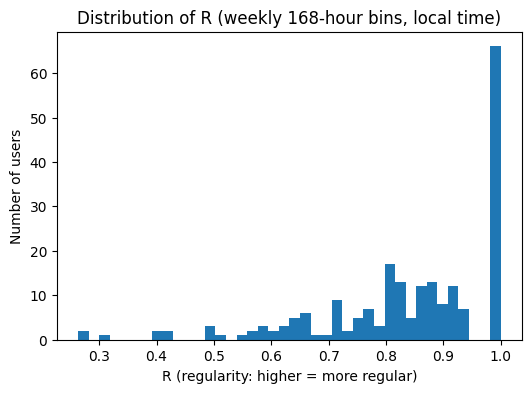


Merged metrics (with R) preview:


,user_id,N_x,S_unc,S_rand,Pi_max,Rg_km,n_points,R,N_y,R_rand
0,240,10,3.321928,3.321928,0.100000,2.597536,10.0,0.700000,10,0.100000
1,741,11,3.459432,3.459432,0.090909,3.161916,11.0,1.000000,11,0.090909
2,2262,5,2.321928,2.321928,0.200000,0.707610,5.0,0.800000,5,0.200000
3,2291,32,4.841625,5.000000,1.000000,2.159015,37.0,0.513514,32,0.031250
4,2328,12,3.546594,3.584963,1.000000,3.479906,13.0,0.846154,12,0.083333


In [29]:
# === 8) Compute regularity R (in 168-hour buckets per week, New York local time) ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Generate "week_hour": the hour number within the week 0..167 (Mon=0)
traj_r = traj_valid.copy()
# pandas 的 dayofweek: Monday=0 ... Sunday=6
traj_r["week_hour"] = traj_r["ts"].dt.dayofweek * 24 + traj_r["ts"].dt.hour

# 2) For each (user_id, week_hour) find the "most frequented venue" (mode)
# Count the number of occurrences of (user, week_hour, venue_id)
cnt = (
    traj_r.groupby(["user_id", "week_hour", "venue_id"], observed=True)
          .size()
          .rename("n")
          .reset_index()
)

# In each (user, week_hour), take the venue_id with the largest number of occurrences
idx = cnt.groupby(["user_id", "week_hour"], observed=True)["n"].idxmax()
pred_rules = cnt.loc[idx, ["user_id", "week_hour", "venue_id"]].rename(columns={"venue_id": "pred_venue"})

# 3) Merge the rules back to the original track to determine if it is a hit
traj_r = traj_r.merge(pred_rules, on=["user_id", "week_hour"], how="left")
traj_r["hit"] = (traj_r["venue_id"] == traj_r["pred_venue"]).astype(int)

# 4) R = hit rate for each user; also given a random baseline R_rand = 1/N (N is the number of different locations)
user_R = (
    traj_r.groupby("user_id", observed=True)["hit"].mean().rename("R").reset_index()
)

# Calculate N (number of different locations)
user_N = traj_r.groupby("user_id", observed=True)["venue_id"].nunique().rename("N").reset_index()
user_R = user_R.merge(user_N, on="user_id", how="left")
user_R["R_rand"] = 1.0 / user_R["N"].replace(0, np.nan)

print("Users with R calculated:", len(user_R))
display(user_R.head())

# 5) Distribution statistics and histograms
print("\nR summary:")
display(user_R["R"].describe(percentiles=[0.25,0.5,0.75,0.9,0.95]))

plt.figure(figsize=(6,4))
plt.hist(user_R["R"], bins=40)
plt.xlabel("R (regularity: higher = more regular)")
plt.ylabel("Number of users")
plt.title("Distribution of R (weekly 168-hour bins, local time)")
plt.show()

#6) Merge into the comprehensive indicator table (if user_metrics / user_entropy exists)
if "user_metrics" in globals():
    user_metrics = user_metrics.merge(user_R, on="user_id", how="left")
elif "user_entropy" in globals():
    user_metrics = user_entropy.merge(user_R, on="user_id", how="left")
else:
    user_metrics = user_R.copy()

print("\nMerged metrics (with R) preview:")
display(user_metrics.head())

# Cross-metric correlation diagram

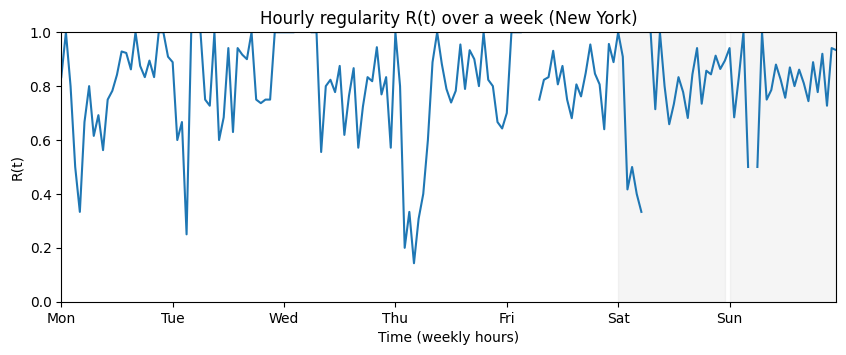

In [30]:
# === Fig.3A: R(t) — hourly regularity over a week ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# generate week_hour（0..167, Mon=0）
rt_df = traj_valid.copy()
rt_df["week_hour"] = rt_df["ts"].dt.dayofweek * 24 + rt_df["ts"].dt.hour

# For each (user, week_hour) find the "most common location" as the rule for that hour
cnt = (
    rt_df.groupby(["user_id", "week_hour", "venue_id"], observed=True)
         .size().rename("n").reset_index()
)
idx = cnt.groupby(["user_id", "week_hour"], observed=True)["n"].idxmax()
rules = cnt.loc[idx, ["user_id", "week_hour", "venue_id"]]\
           .rename(columns={"venue_id":"pred_venue"})

# hit 
rt_df = rt_df.merge(rules, on=["user_id","week_hour"], how="left")
rt_df["hit"] = (rt_df["venue_id"] == rt_df["pred_venue"]).astype(int)

# The average hit rate of all users in each hour-bin, R(t)
R_t = rt_df.groupby("week_hour", observed=True)["hit"].mean().reindex(range(168))

plt.figure(figsize=(10,3.5))
plt.plot(R_t.values)
plt.ylim(0,1.0)
plt.xlim(0,167)
plt.xticks([0,24,48,72,96,120,144],
           ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.xlabel("Time (weekly hours)")
plt.ylabel("R(t)")
plt.title("Hourly regularity R(t) over a week (New York)")
# Gray weekend area
for s in [(5*24, 6*24-1), (6*24, 7*24-1)]:
    plt.axvspan(s[0], s[1], alpha=0.08, color="gray")
plt.show()

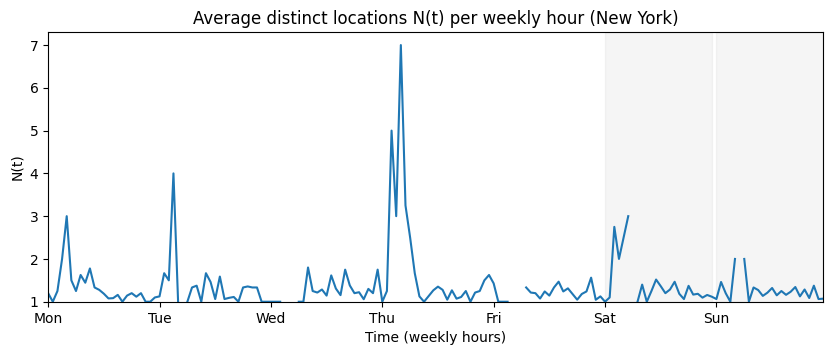

In [31]:
# === Fig.3B: N(t) — average # of distinct locations at each hourly slot ===
# Explanation: For each user and week hour (user, week_hour), count the number of unique locations visited during that hour.
# (This may be different locations across multiple weeks), then average this across users to get N(t)
nt_df = traj_valid.copy()
nt_df["week_hour"] = nt_df["ts"].dt.dayofweek * 24 + nt_df["ts"].dt.hour

# (user, week_hour) distinct venues
user_wh_N = (
    nt_df.groupby(["user_id","week_hour"], observed=True)["venue_id"]
         .nunique().rename("N_wh").reset_index()
)

# N(t) = mean of user
N_t = user_wh_N.groupby("week_hour", observed=True)["N_wh"].mean().reindex(range(168))

plt.figure(figsize=(10,3.5))
plt.plot(N_t.values)
plt.xlim(0,167)
plt.ylim(bottom=1)
plt.xticks([0,24,48,72,96,120,144],
           ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.xlabel("Time (weekly hours)")
plt.ylabel("N(t)")
plt.title("Average distinct locations N(t) per weekly hour (New York)")
for s in [(5*24, 6*24-1), (6*24, 7*24-1)]:
    plt.axvspan(s[0], s[1], alpha=0.08, color="gray")
plt.show()

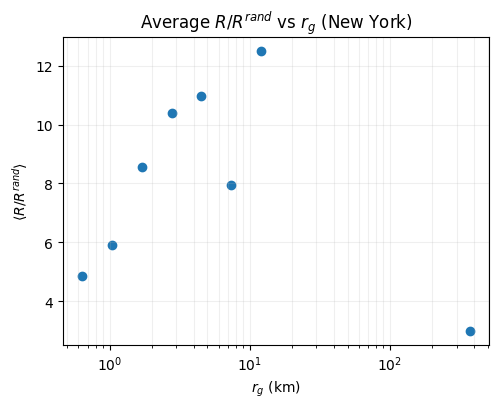

In [32]:
# === Fig.3C: <R / R_rand> vs r_g  — binned by Rg_km (log bins) ===
# User-level R, R_rand, and Rg_km are needed. If already in user_metrics, use them.
# Otherwise, merge them with the previously calculated user_R.
if "user_metrics" in globals():
    rr_df = user_metrics.copy()
else:
    rr_df = user_R.copy()
    if "Rg_km" not in rr_df.columns:
        rr_df = rr_df.merge(user_rg[["user_id","Rg_km"]], on="user_id", how="left")

# Calculate relative regularity R/R_rand (filter outliers and division by zero)
rr_df = rr_df.copy()
rr_df = rr_df[(rr_df["R_rand"] > 0) & np.isfinite(rr_df["R_rand"]) & np.isfinite(rr_df["R"])]
rr_df["R_rel"] = rr_df["R"] / rr_df["R_rand"]

# Bin Rg on a logarithmic scale
eps = 1e-6
rg_min = max(0.5, rr_df["Rg_km"].replace(0, np.nan).min(skipna=True) or 0.5)
rg_max = max(1.5, rr_df["Rg_km"].max())
bins = np.logspace(np.log10(rg_min), np.log10(rg_max+eps), num=15)  # 15 log bins

rr_df["rg_bin"] = pd.cut(rr_df["Rg_km"].clip(lower=rg_min), bins=bins, include_lowest=True)

# Take the average <R/R_rand> in each bin and the geometric mean of the bin as x
def geom_mid(b):
    left, right = b.left, b.right
    return np.sqrt(left*right)

summary = (
    rr_df.groupby("rg_bin", observed=True)["R_rel"]
         .agg(["count","mean"])
         .reset_index()
         .dropna()
)
summary["rg_mid"] = summary["rg_bin"].apply(geom_mid)

plt.figure(figsize=(5.5,4))
plt.scatter(summary["rg_mid"], summary["mean"])
plt.xscale("log")
plt.xlabel(r"$r_g$ (km)")
plt.ylabel(r"$\langle R / R^{rand} \rangle$")
plt.title(r"Average $R/R^{rand}$ vs $r_g$ (New York)")
plt.grid(alpha=0.2, which="both")
plt.show()